Following [https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/discussion]

In [1]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from patsy import dmatrices, dmatrix
import re
import operator
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_original = pd.read_csv("input/train.csv", index_col='PassengerId')
test_original = pd.read_csv("input/test.csv", index_col='PassengerId')
full = pd.concat([train_original, test_original])

# Extraindo title and surname

In [3]:
full['Title'] = full["Name"].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))

In [4]:
full["NameLength"] = full["Name"].apply(lambda x: len(x))

In [6]:
title_size = full.groupby('Title').size()
full.loc[full['Title'].isin(['Mlle', 'Ms']), 'Title'] = 'Miss'
full.loc[full['Title'].isin(['Mme']), 'Title'] = 'Mrs'
rares = title_size[title_size <= 10].index
full.loc[full['Title'].isin(rares), 'Title'] = 'Rare'
print(full.groupby(['Sex', 'Title']).size())

Sex     Title 
female  Miss      264
        Mrs       198
        Rare        4
male    Master     61
        Mr        757
        Rare       25
dtype: int64


In [7]:
full['surname'] = full["Name"].apply(lambda x: x.split(',')[0].lower())

In [8]:
full['surname'].head()

PassengerId
1       braund
2      cumings
3    heikkinen
4     futrelle
5        allen
Name: surname, dtype: object

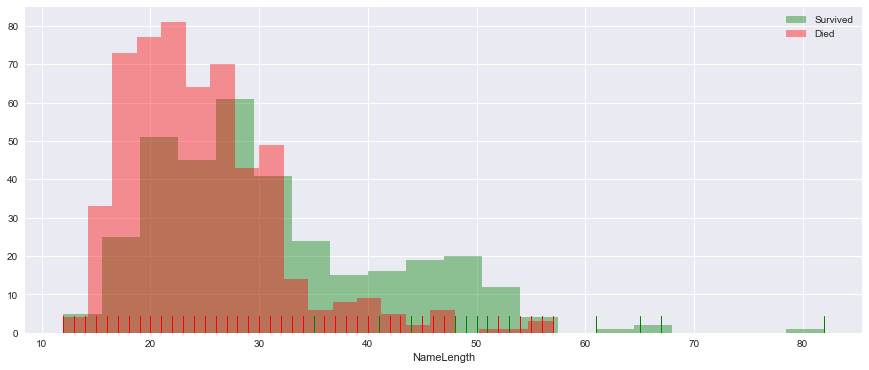

In [9]:
f, ax = plt.subplots(figsize=(15, 6))
sns.distplot(full[full['Survived'] == 1.0]['NameLength'], bins=20, kde=False, rug=True, label='Survived', color='g');
sns.distplot(full[full['Survived'] == 0.0]['NameLength'], bins=20, kde=False, rug=True, label='Died', color='r');
ax.legend()
sns.despine(left=True, bottom=True)

# Extraindo family and fsize

In [10]:
full['Fsize'] = full['SibSp'] + full['Parch'] + 1

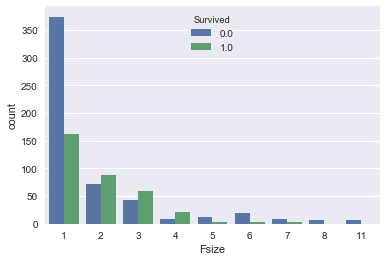

In [11]:
sns.countplot(x='Fsize', hue='Survived', data=full)

In [12]:
full['FsizeD'] = pd.cut(full["Fsize"], bins=[0,1,4,20], labels=['single','small','large'])

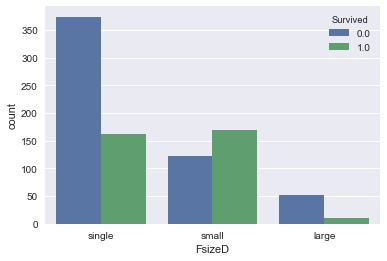

In [13]:
sns.countplot(x='FsizeD', hue='Survived', data=full)

## Extract Deck

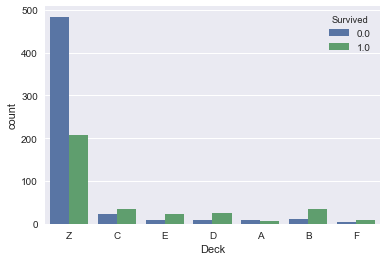

In [14]:
full['Deck'] = full['Cabin'].fillna('Z0').apply(lambda x: x[0])
full.loc[full['Deck'].isin(['T', 'G']), 'Deck'] = 'Z'
sns.countplot(x='Deck', hue='Survived', data=full)

# Fix Embarked

In [15]:
full[full['Embarked'].isnull()][['Fare', 'Pclass']]

,Fare,Pclass
PassengerId,,
62,80.0,1
830,80.0,1


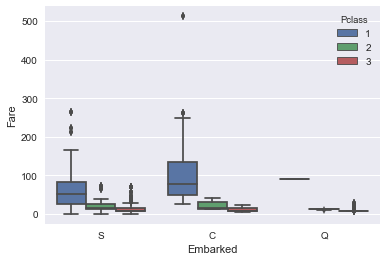

In [16]:
#sns.jointplot(x="Age", y="Survived", kind="hex", data=df);
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=full)

In [17]:
# Todos os passageiros com Embarked null se encaixam no Q
full.loc[[62, 830], 'Embarked'] = 'Q'

## Fix Fare

In [18]:
full[full['Fare'].isnull()][['Pclass', 'Embarked']]

,Pclass,Embarked
PassengerId,,
1044,3,S


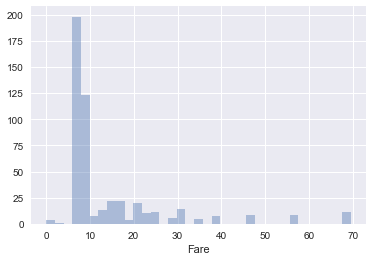

In [19]:
embS_clas3_fare = full[ \
                       (full['Embarked'] == 'S') & \
                       (full['Pclass'] == 3)] \
                ['Fare'].dropna()
sns.distplot(embS_clas3_fare, kde=False)

In [20]:
full.loc[1044, 'Fare'] = embS_clas3_fare.median()

## Fix Age By Regression

In [21]:
ageTrainY, ageTrainX = dmatrices('Age ~ Title', data=full[full['Age'].notnull()], return_type='dataframe', NA_action = 'raise')
ageTrainX

,Intercept,Title[T.Miss],Title[T.Mr],Title[T.Mrs],Title[T.Rare]
PassengerId,,,,,
1,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0
5,1.0,0.0,1.0,0.0,0.0
7,1.0,0.0,1.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,1.0,0.0
10,1.0,0.0,0.0,1.0,0.0


In [22]:
formula_ml = '~ Fare + Parch + SibSp + Fsize + NameLength + C(Pclass) + C(Title) + C(Sex) + C(Embarked)'
# Create the random forest model and fit the model to our training data
ageTrainY, ageTrainX = dmatrices('Age ' + formula_ml, data=full[full['Age'].notnull()], return_type='dataframe', NA_action = 'raise')
_, ageTestX = dmatrices('1 ' + formula_ml, data=full[full['Age'].isnull()], return_type='dataframe', NA_action = 'raise')

etr = ExtraTreesRegressor(n_estimators=200)
etr.fit(X = ageTrainX, y = np.ravel(ageTrainY))
age_preds = etr.predict(ageTestX)
full.loc[full['Age'].isnull(), 'Age'] = age_preds
print('Score: {:.2%}'.format(etr.score(X = ageTrainX, y = np.ravel(ageTrainY))))
pd.DataFrame({'name': ageTrainX.columns, 'value': etr.feature_importances_}).sort_values('value', ascending=False)

Score: 93.67%


,name,value
10,Fare,0.204563
14,NameLength,0.191134
2,C(Pclass)[T.3],0.121291
11,Parch,0.092106
4,C(Title)[T.Mr],0.087923
5,C(Title)[T.Mrs],0.074496
1,C(Pclass)[T.2],0.062322
3,C(Title)[T.Miss],0.049121
13,Fsize,0.038081
12,SibSp,0.022615


# Add Mother e Child

In [23]:
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,NameLength,surname,Fsize,FsizeD,Deck
PassengerId,,,,,,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,Mr,23,braund,2,small,Z
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,Mrs,51,cumings,2,small,C
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,Miss,22,heikkinen,1,single,Z
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,Mrs,44,futrelle,2,small,C
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,Mr,24,allen,1,single,Z


In [24]:
full['Child'] = (full['Age'] < 18).astype(int)
full['Mother'] = ((full['Sex'] == 'female') \
                      & (full['Parch'] > 0) \
                      & (full['Age'] > 18) \
                      & (full['Title'] != 'Miss')).astype(int)

In [25]:
full.groupby(['Mother', 'Survived']).size()

Mother  Survived
0       0.0         533
        1.0         303
1       0.0          16
        1.0          39
dtype: int64

# Training

## Cria a matriz para treino

In [26]:
#drop_columns = ['Cabin', 'Name', 'Ticket', 'surname', 'Fsize']
train = full.loc[train_original.index]
test = full.loc[test_original.index]

In [27]:
formula_ml = 'Age + Embarked + NameLength + Fare + Parch + Pclass + Sex + SibSp + Title + FsizeD + Deck + Child + Mother - 1'
train_y, train_x = dmatrices('Survived ~ ' + formula_ml, data=train, return_type='dataframe')
test_x = dmatrix(formula_ml, data=test, return_type='dataframe')
train_y = np.ravel(train_y)

## SelectKBest

In [28]:
selector = SelectKBest(f_classif, k=len(train_x.columns))
selector.fit(train_x, train_y)
scores = -np.log10(selector.pvalues_)
pd.DataFrame({'name': train_x.columns, 'value': scores}).sort_values('value', ascending=False)

,name,value
5,Title[T.Mr],70.614611
3,Sex[T.male],68.851994
6,Title[T.Mrs],25.121915
20,Pclass,24.595671
4,Title[T.Miss],24.174314
17,NameLength,23.693190
15,Deck[T.Z],21.833804
8,FsizeD[T.small],16.768941
18,Fare,14.213235
10,Deck[T.B],6.841160


## RandomForest

In [29]:
rfc = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255}, random_state=1)

In [29]:
kf = KFold(n_splits=3, random_state=1)
scores = cross_val_score(rfc, X=train_x, y=train_y, cv=kf)
print("Accuracy: {:.3%} (+/- {:.2%}) {}".format(scores.mean(), scores.std(), 'RFC Cross Validation'))
# Base: 83.165% (+/- 0.99%) RFC Cross Validation

Accuracy: 83.053% (+/- 1.14%) RFC Cross Validation


In [30]:
rfc.fit(train_x, train_y)
score = rfc.score(train_x, train_y)
print("Accuracy: {:.3%} {}".format(score, 'RFC full test'))
pd.DataFrame({'name': train_x.columns, 'value': rfc.feature_importances_}).sort_values('value', ascending=False)

Accuracy: 94.837% RFC full test


,name,value
18,Fare,0.143605
17,NameLength,0.142401
16,Age,0.142346
3,Sex[T.male],0.103181
5,Title[T.Mr],0.090440
20,Pclass,0.076046
4,Title[T.Miss],0.038176
6,Title[T.Mrs],0.035617
15,Deck[T.Z],0.035191
21,SibSp,0.028048


In [31]:
predictions = rfc.predict(test_x)
result = pd.DataFrame({'Survived': predictions.astype(int)}, index=test_x.index) 

In [32]:
last_result = pd.DataFrame.from_csv('last_result.csv', index_col='PassengerId')
last_result['New'] = result['Survived']
total = len(last_result)
diffCount = len(last_result[last_result['New'] != last_result['Survived']])
print("Equals: {}, Diff: {} - {:.2%}".format(total - diffCount, diffCount, float(diffCount)/total));

Equals: 388, Diff: 30 - 7.18%


In [33]:
result_file_name = 'test_predict_{:%Y%m%d%H%M%S}.csv'.format(datetime.now())
result.to_csv(result_file_name)
print('Predict saved as ' + result_file_name)

Predict saved as test_predict_20170210002921.csv
